<a href="https://colab.research.google.com/github/vikki284/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt

# Define the generator (UNet architecture)
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0),  # Adjust input channels to 3
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0),  # Adjust input channels to 3
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        return x

# Custom dataset class
class FaceDataset(Dataset):
    def __init__(self, root_dir_sketch, root_dir_real, transform=None):
        self.root_dir_sketch = root_dir_sketch
        self.root_dir_real = root_dir_real
        self.transform = transform
        self.sketch_files = os.listdir(root_dir_sketch)
        self.real_files = os.listdir(root_dir_real)

    def __len__(self):
        return min(len(self.sketch_files), len(self.real_files))

    def __getitem__(self, idx):
        sketch_img_name = os.path.join(self.root_dir_sketch, self.sketch_files[idx])
        real_img_name = os.path.join(self.root_dir_real, self.real_files[idx])
        sketch_image = Image.open(sketch_img_name).convert('RGB')  # Adjust to RGB
        real_image = Image.open(real_img_name)

        if self.transform:
            sketch_image = self.transform(sketch_image)
            real_image = self.transform(real_image)

        return sketch_image, real_image

# Function to display generated images during training
def show_generated_images(generator, noise, num_images=5, device='cpu'):
    with torch.no_grad():
        fake_images = generator(noise).cpu().detach()
        fake_images = fake_images.view(-1, 3, 256, 256)[:num_images]
        fake_images = (fake_images + 1) / 2  # Unnormalize

        fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
        for i in range(num_images):
            axes[i].imshow(fake_images[i].permute(1, 2, 0))
            axes[i].axis('off')
        plt.show()

# Hyperparameters
batch_size = 8
num_epochs = 25
lr = 0.002
device ="cpu"

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
root_dir_sketch = r"D:\Dev_Vikram_Robotics_and_AI\SKETCH_1000"
root_dir_real = r"D:\Dev_Vikram_Robotics_and_AI\REAL_1000"
dataset = FaceDataset(root_dir_sketch, root_dir_real, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize generator and discriminator
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)

# Define loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Specify the directory where you want to save the model files
save_dir = r"D:\Dev_Vikram_Robotics_and_AI\MODELS"

# Training loop
for epoch in range(num_epochs):
    for i, (sketch_images, real_images) in enumerate(dataloader):
        sketch_images = sketch_images.to(device)
        real_images = real_images.to(device)

        # Train discriminator
        optimizer_D.zero_grad()
        fake_images = generator(sketch_images)
        real_preds = discriminator(real_images)
        fake_preds = discriminator(fake_images.detach())
        real_loss = criterion(real_preds, torch.ones_like(real_preds))
        fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()
        fake_preds = discriminator(fake_images)
        g_loss = criterion(fake_preds, torch.ones_like(fake_preds))
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}], Batch Step [{i}/{len(dataloader)}], "
                f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}"
            )

    # Save the model after each epoch
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'g_loss': g_loss,
        'd_loss': d_loss
    }, os.path.join(save_dir, f"model_epoch_{epoch}.pt"))

    if (epoch + 1) % 5 == 0:
        try:
            # Save generated images and display
            show_generated_images(generator, sketch_images[:min(num_images, len(sketch_images))], device=device)
        except Exception as e:
            print(f"Error occurred during image generation and display: {e}")



Epoch [0/25], Batch Step [0/26], Generator Loss: 1.2933, Discriminator Loss: 0.7116
Epoch [1/25], Batch Step [0/26], Generator Loss: 0.8252, Discriminator Loss: 0.7187
Epoch [2/25], Batch Step [0/26], Generator Loss: 0.9232, Discriminator Loss: 0.6855
Epoch [3/25], Batch Step [0/26], Generator Loss: 0.7740, Discriminator Loss: 0.6780
Epoch [4/25], Batch Step [0/26], Generator Loss: 1.0648, Discriminator Loss: 0.8029
Error occurred during image generation and display: name 'num_images' is not defined
Epoch [5/25], Batch Step [0/26], Generator Loss: 1.3235, Discriminator Loss: 0.6386
Epoch [6/25], Batch Step [0/26], Generator Loss: 1.0315, Discriminator Loss: 0.5346
Epoch [7/25], Batch Step [0/26], Generator Loss: 2.0005, Discriminator Loss: 0.5539
Epoch [8/25], Batch Step [0/26], Generator Loss: 1.4713, Discriminator Loss: 0.2470
Epoch [9/25], Batch Step [0/26], Generator Loss: 2.6073, Discriminator Loss: 0.8716
Error occurred during image generation and display: name 'num_images' is no

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


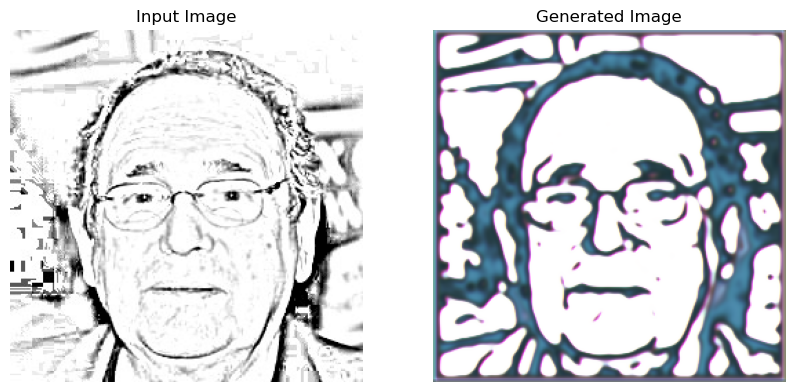

In [ ]:
# Load the saved generator model
generator_path = r"D:\Dev_Vikram_Robotics_and_AI\MODELS\model_epoch_12.pt"

# Assuming you have a single input image
input_image_path = r"D:\Dev_Vikram_Robotics_and_AI\sketch_data\00001.jpg"
input_image = Image.open(input_image_path).convert('RGB')  # Adjust to RGB
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
input_image = transform(input_image).unsqueeze(0)  # Add batch dimension

# Load the saved generator model state dictionary only
checkpoint = torch.load(generator_path, map_location=torch.device('cpu'))
generator = UNetGenerator()
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

# Generate output image
with torch.no_grad():
    output_image = generator(input_image).squeeze(0).permute(1, 2, 0)
    output_image = (output_image + 1) / 2  # Unnormalize if necessary

# Display the input and output images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image.squeeze(0).permute(1, 2, 0))
axes[0].set_title('Input Image')
axes[0].axis('off')
axes[1].imshow(output_image)
axes[1].set_title('Generated Image')
axes[1].axis('off')
plt.show()